# Gaussian Receptive Fields

## Description
Temporal Encoding of continous input data. 

## Paper 
Wang, J., Belatreche, A., Maguire, L., & Mcginnity, T. M. (2014). An online supervised learning method for spiking neural networks with adaptive structure. Neurocomputing, 144, 526-536.

### Contributor
Ajinkya Indulkar

In [2]:
# import libraries
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt

%matplotlib inline

In [244]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [4]:
# input vector
x = X[0]
x_min = min(x)
x_max = max(x)

In [5]:
# define parameters
n = 20 # number of neurons
sigma = 0.5 # standard deviation

#### Compute Gaussian Receptive Fields

In [6]:
# compute expectation
mu = x_min + (x_max - x_min) * np.arange(0, n, 1) / (n-1)
mu

array([0.2       , 0.45789474, 0.71578947, 0.97368421, 1.23157895,
       1.48947368, 1.74736842, 2.00526316, 2.26315789, 2.52105263,
       2.77894737, 3.03684211, 3.29473684, 3.55263158, 3.81052632,
       4.06842105, 4.32631579, 4.58421053, 4.84210526, 5.1       ])

In [7]:
# compute gaussian receptive fields
grf = []
for i in range(n):
    result = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * np.divide(np.square(x - mu[i]),
                                                                          np.square(sigma)), 
                                                       dtype=np.double)
    grf.append(result)
grf = np.array(grf)

#### Plot Gaussian Receptive Fields

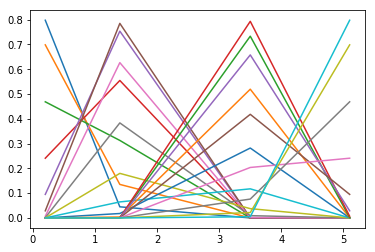

In [8]:
for i in range(n):
    plt.plot(x, grf[i])

#### Compute Spike Timings

In [9]:
spike_time_ms = 10
spike_times = []
for i in range(len(x)):
    grf_values = [-spike_time_ms*g[i]+spike_time_ms for g in grf]
    spike_times.append([-1 if g>=spike_time_ms-1 else g for g in grf_values])
    
spike_times = np.array(spike_times)

In [10]:
spike_times[2]

array([-1.        ,  8.64788628,  6.87165018,  4.45274375,  2.46120437,
        2.14788706,  3.73195753,  6.16524035,  8.20193581, -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ])

In [11]:
spike_times.shape

(4, 20)

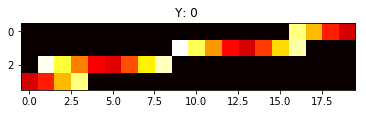

In [12]:
plt.imshow(spike_times, cmap='hot', interpolation='nearest')
plt.title("Y: {} ".format(y[0]))
plt.show()

### Packaging GRF

In [13]:
def gaussianRF(x, sigma=0.5, n=20, spike_time_ms=10):
    """
    Encoding input vector x via gaussian receptive fields
    """
    # compute max and min of input
    x_min = min(x)
    x_max = max(x)
    # compute expectation
    mu = x_min + (x_max - x_min) * np.arange(0, n, 1) / (n-1)
    # compute gaussian receptive fields
    grf = []
    for i in range(n):
        result = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * np.divide(np.square(x - mu[i]),
                                                                              np.square(sigma)), 
                                                           dtype=np.double)
        grf.append(result)
    grf = np.array(grf)
    spike_times = []
    for i in range(len(x)):
        grf_values = [-spike_time_ms*g[i]+spike_time_ms for g in grf]
        spike_times.append([-1 if g>=spike_time_ms-1 else g for g in grf_values])

    spike_times = np.array(spike_times)
    return spike_times

In [14]:
def visualize_spikes(spike_times, label):
    plt.figure()
    plt.imshow(spike_times, cmap='hot', interpolation='nearest')
    plt.title("Label: {} ".format(label))
    plt.show()

### Encoding IRIS Dataset using GRF

In [15]:
from sklearn import preprocessing

In [16]:
X_norm = preprocessing.normalize(X, axis=0)

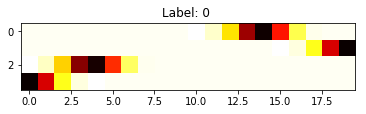

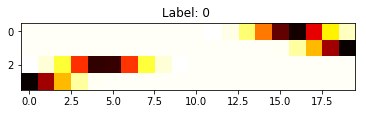

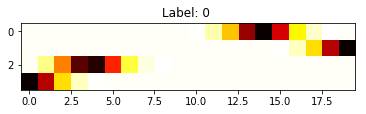

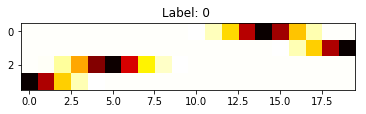

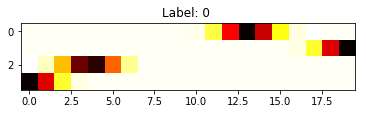

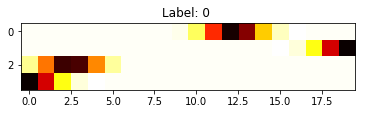

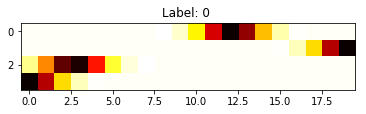

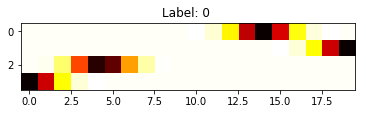

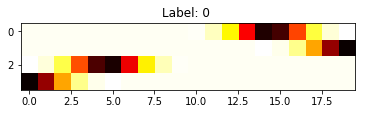

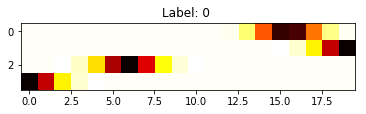

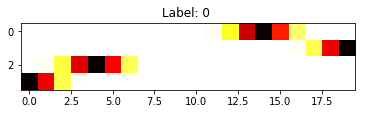

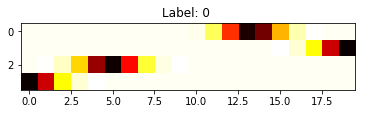

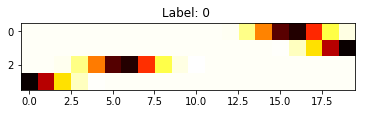

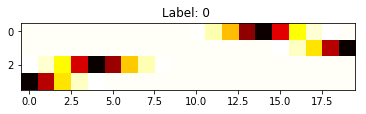

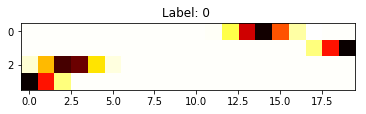

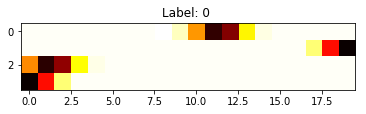

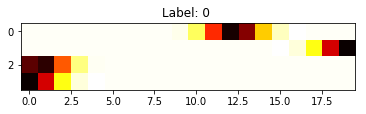

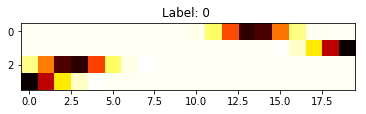

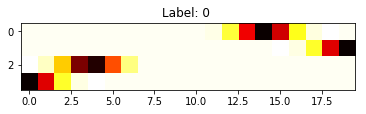

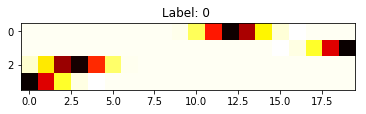

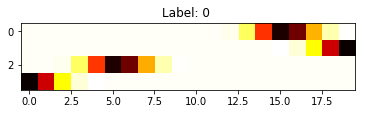

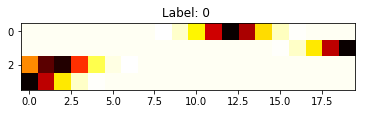

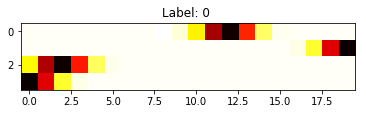

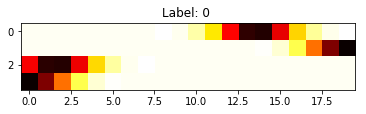

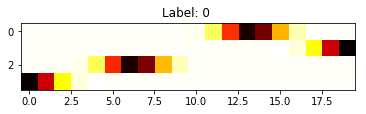

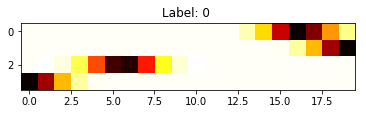

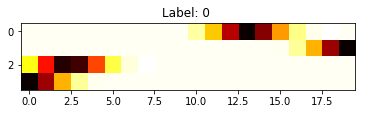

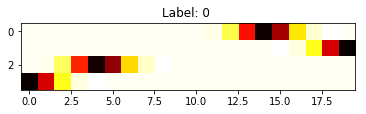

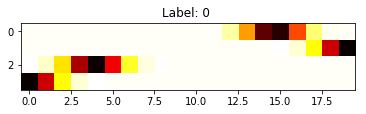

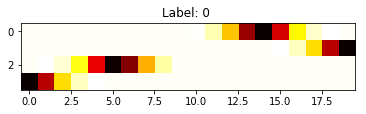

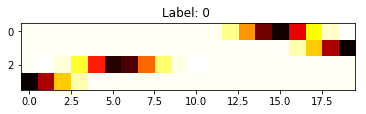

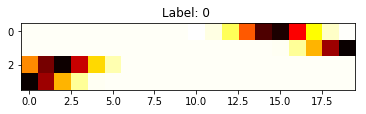

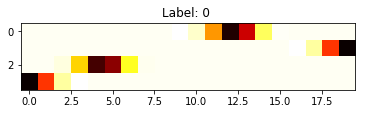

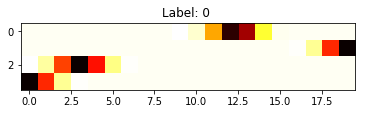

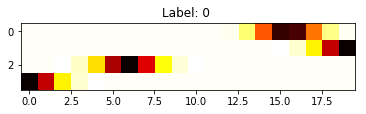

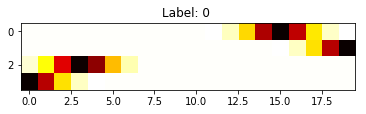

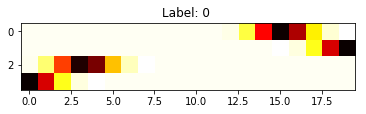

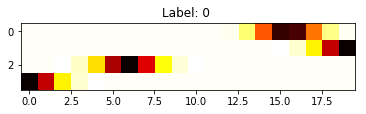

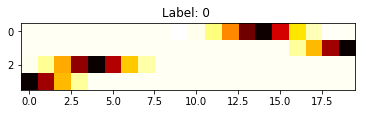

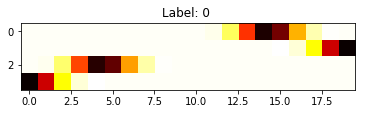

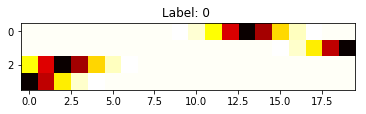

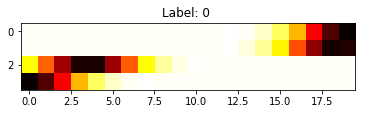

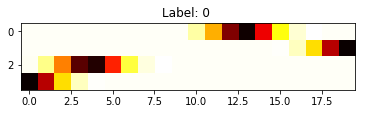

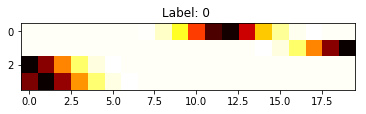

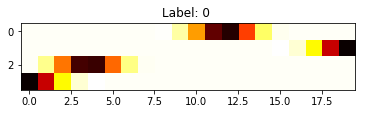

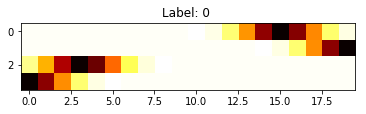

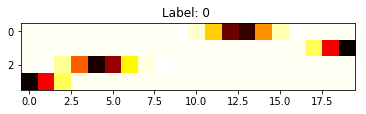

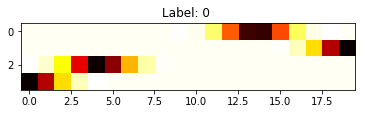

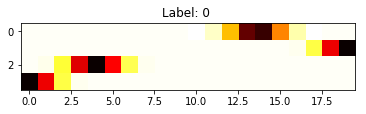

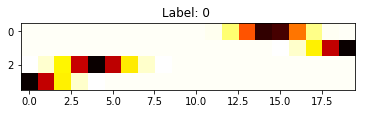

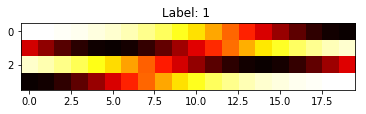

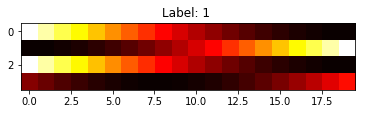

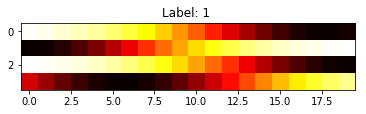

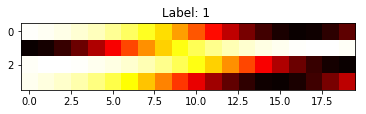

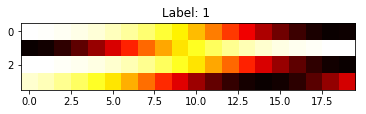

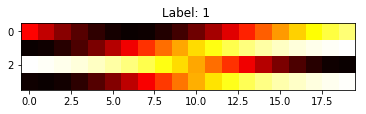

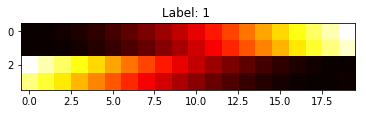

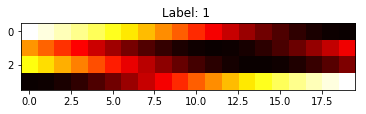

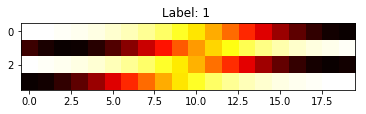

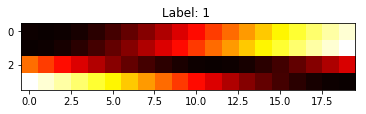

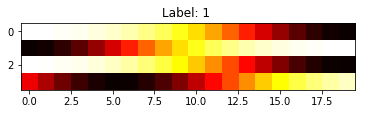

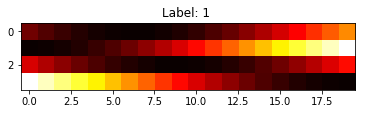

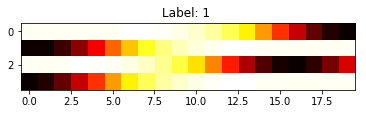

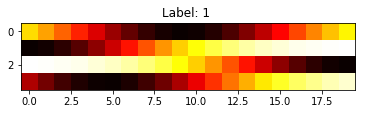

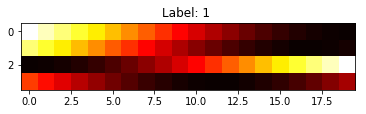

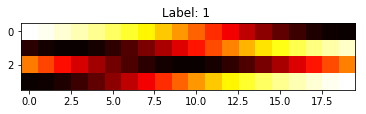

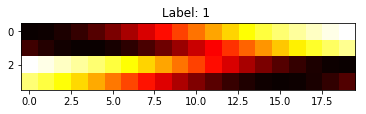

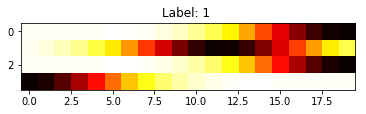

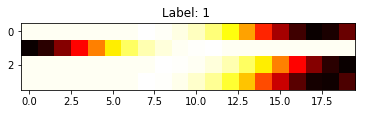

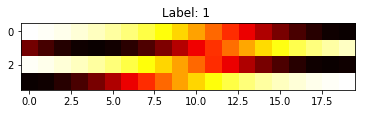

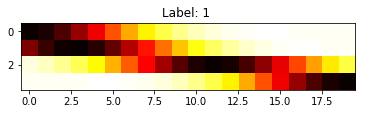

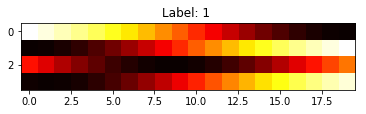

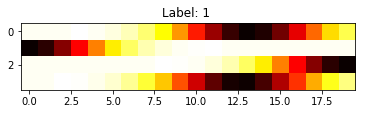

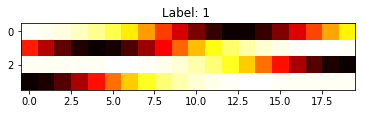

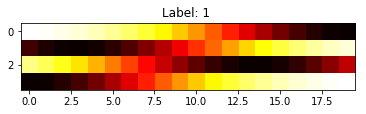

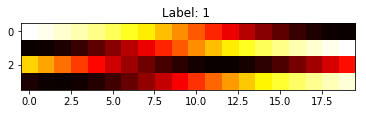

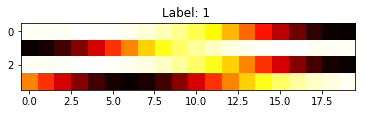

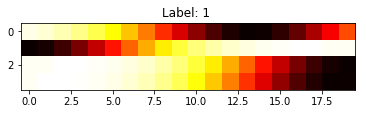

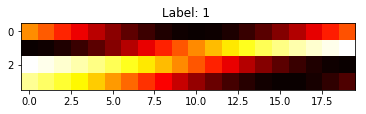

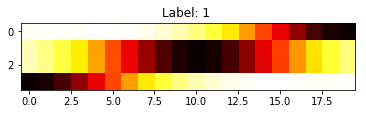

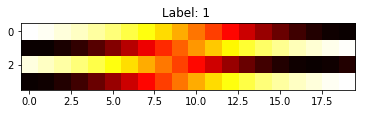

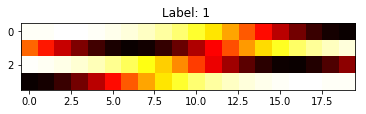

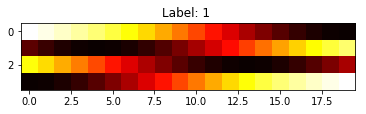

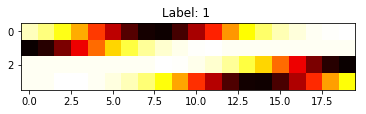

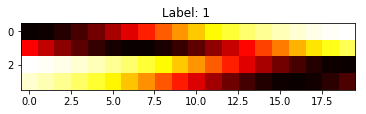

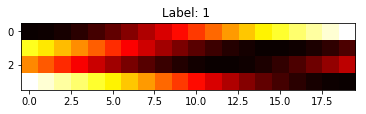

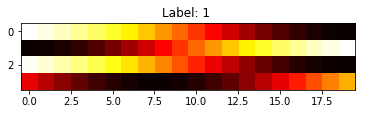

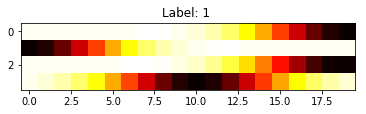

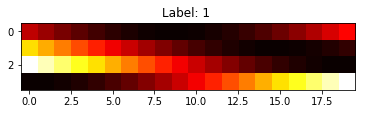

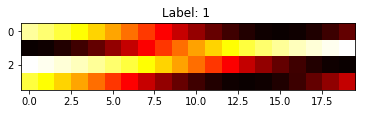

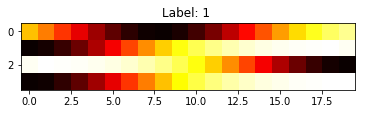

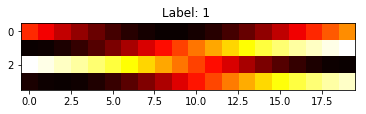

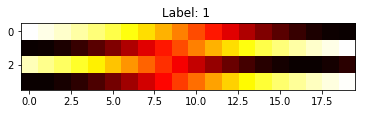

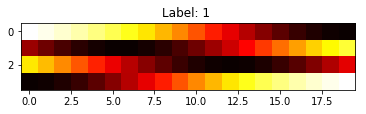

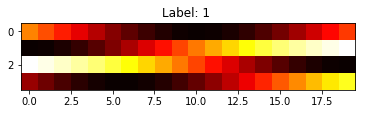

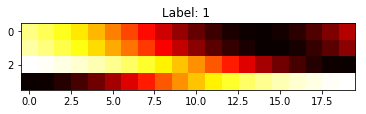

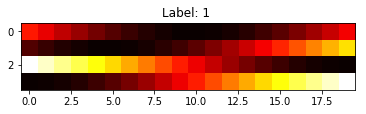

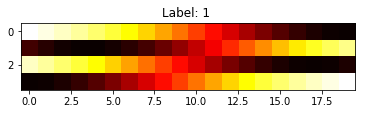

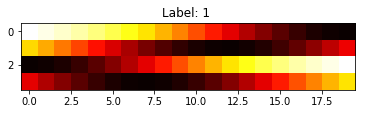

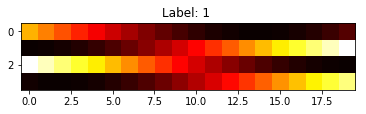

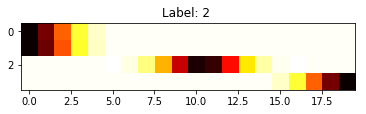

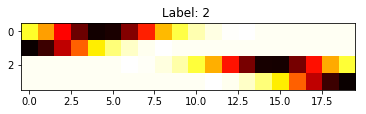

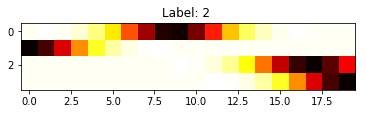

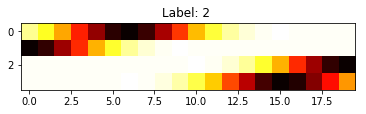

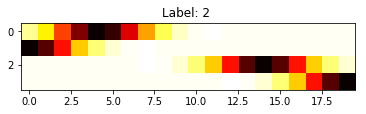

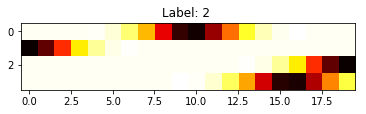

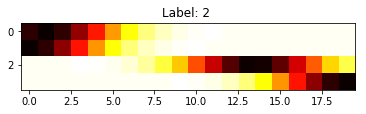

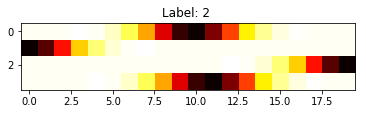

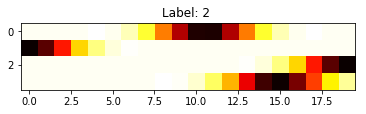

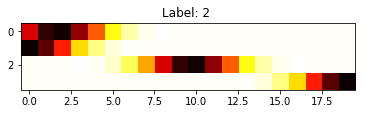

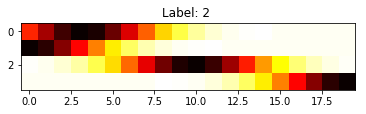

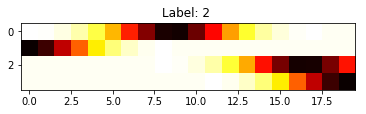

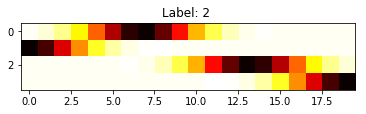

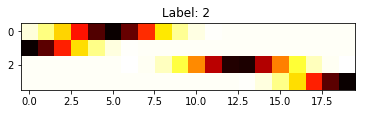

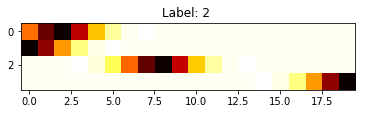

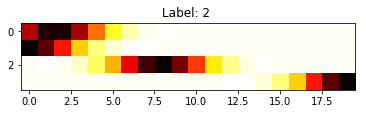

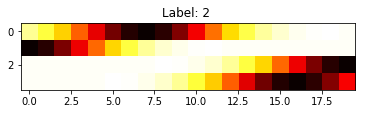

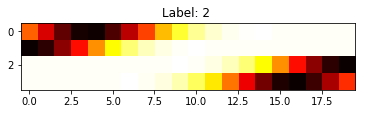

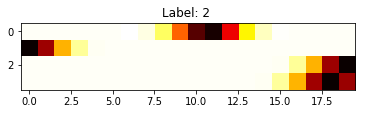

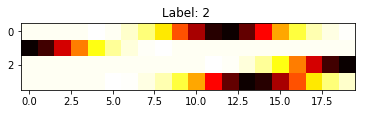

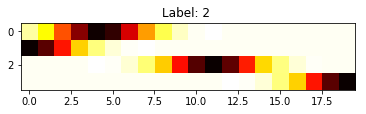

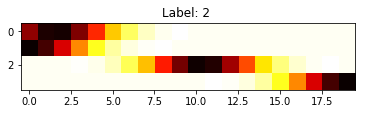

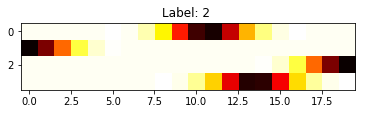

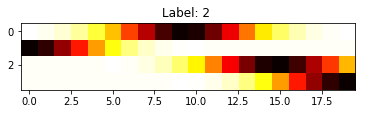

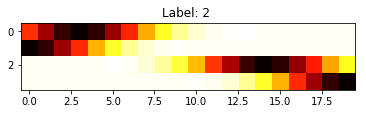

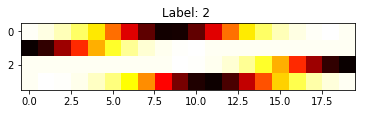

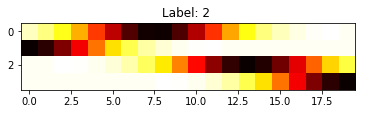

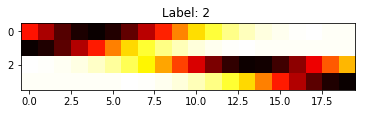

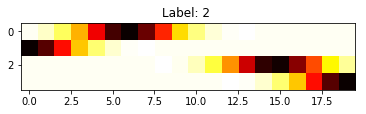

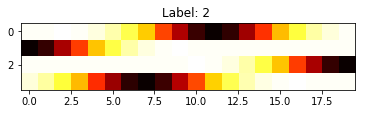

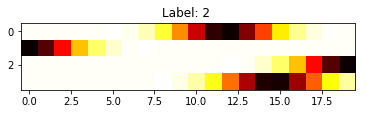

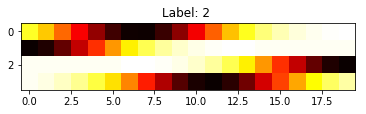

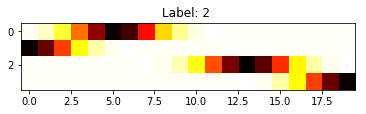

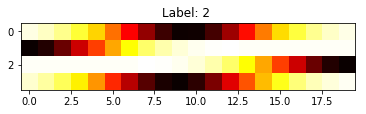

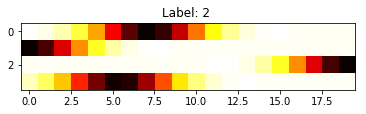

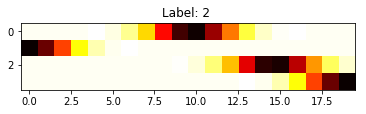

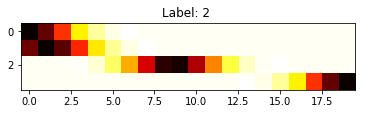

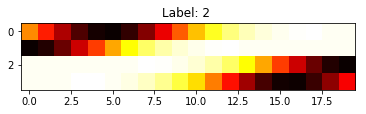

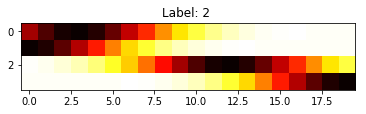

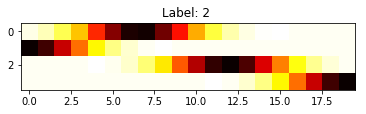

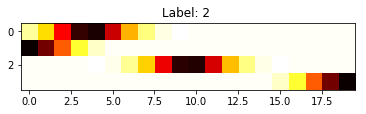

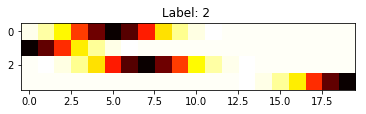

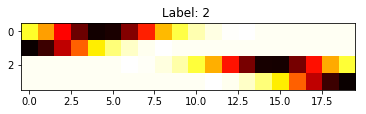

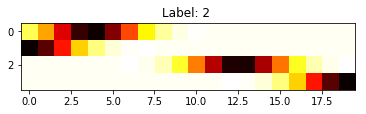

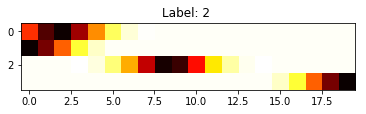

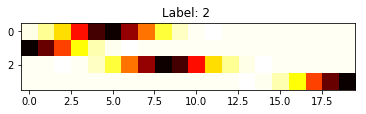

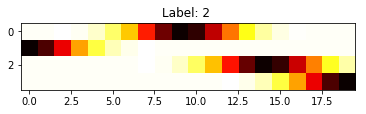

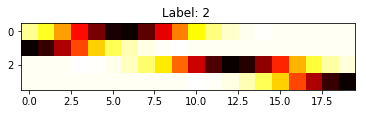

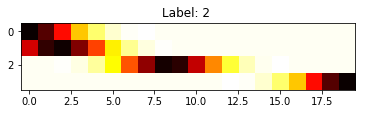

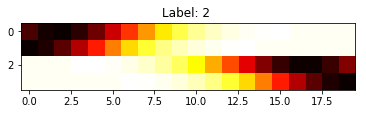

In [17]:
for i in range(len(X)):
    visualize_spikes(gaussianRF(X_norm[i], sigma=0.005, spike_time_ms=6), y[i])

# Now we transfer the spikes into nengo 

In [260]:
# Encode the features 
def sp(spike_times,j):
    spike_t = (spike_times[j][spike_times[j]>0])/10
    return [round(i,2) for i in spike_t ]

spikes=[]
for i in range(4):
    spikes.append(sp(spike_times,i))
    
# Encode the class 0,1,2 meaning a spike in c_1, c_2 or c_3
clasOfSample = 0


In [261]:
spikes # Form a list with each spike time for each feature 

[[0.76, 0.53, 0.3, 0.2],
 [0.88, 0.72, 0.48, 0.27, 0.21, 0.34, 0.58, 0.8],
 [0.86, 0.69, 0.45, 0.25, 0.21, 0.37, 0.62, 0.82],
 [0.2, 0.3, 0.53, 0.76]]

In [431]:
import nengo
from nengo.utils.neurons import spikes2events
from nengo.solvers import LstsqL2

with model:

    def spike_1(t):
        return (t in spikes[0])*30  # Every time t is equal to the value there is a spike 
    def spike_2(t):
        return (t in spikes[1])*30
    def spike_3(t):
        return (t in spikes[2])*30
    def spike_4(t):
        return (t in spikes[3])*30
    
    def clas_1(t):
        return clasOfSample==0
    def clas_2(t):
        return clasOfSample==1
    def clas_3(t):
        return clasOfSample==2
    
    
        
    stim1 = nengo.Node(spike_1)
    stim2 = nengo.Node(spike_2)
    stim3 = nengo.Node(spike_3)
    stim4 = nengo.Node(spike_4)
    
    Input = nengo.Ensemble(n_neurons=100, dimensions=4 )
    post = nengo.Ensemble(n_neurons=100, dimensions=3 )
    
    pre = nengo.Ensemble(n_neurons=100, dimensions=3 )
    
    nengo.Connection(stim1, Input[0])
    nengo.Connection(stim2, Input[1])
    nengo.Connection(stim3, Input[2])
    nengo.Connection(stim4, Input[3])
    p = nengo.Probe(Input, synapse=0.01)
    
    
    #Training 
    conn = nengo.Connection(Input, pre, function=lambda x: np.random.random(3))
    # ------ Define the pre and post ensembles 
    error = nengo.Ensemble(60, dimensions=3)
    error_p = nengo.Probe(error, synapse=0.01)
    #----------
    
    post_1 = nengo.Node(clas_1)
    post_2 = nengo.Node(clas_2)
    post_3 = nengo.Node(clas_3)
    nengo.Connection(post_1, post[0])
    nengo.Connection(post_2, post[1])
    nengo.Connection(post_3, post[2])
    

    

    #nengo.Connection(a, c_2)
    #nengo.Connection(a, c_3)
#--------
    nengo.Connection(post, error,transform=[-1,-1,-1])
    nengo.Connection(pre, error,transform=[1,1,1])

    #-------------
    probe_pre_1 = nengo.Probe(pre, synapse=0.01)
    #-------------
    probe_post = nengo.Probe(post, synapse=0.01)
    
    #-------
    # Add the learning rule to the connection
     # Add the learning rule to the connection
    conn.learning_rule_type = nengo.PES()

    # Connect the error into the learning rule
    nengo.Connection(error, conn.learning_rule)

with nengo.Simulator(model) as sim:
    sim.run(1)
    



HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

# The spikes distributed in a second.

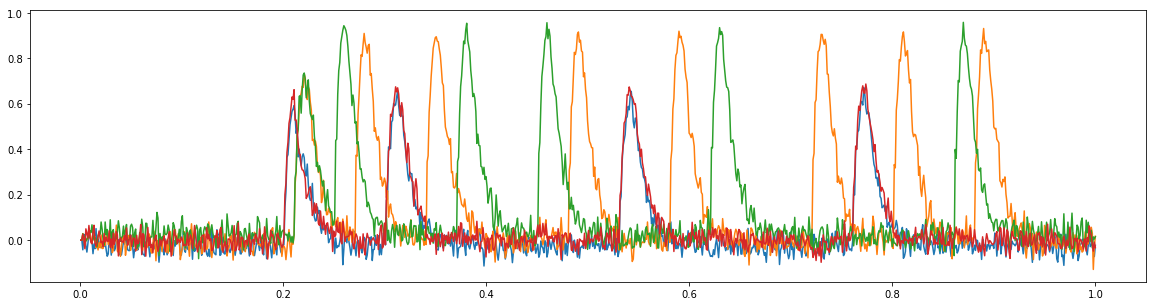

In [432]:
# Spikes
plt.figure(figsize=(20,5))
plt.plot(sim.trange(), sim.data[p])

# The blue color represents the values of the ensembel asociated with class 1
In this case all clases should be zero exept for the first one 

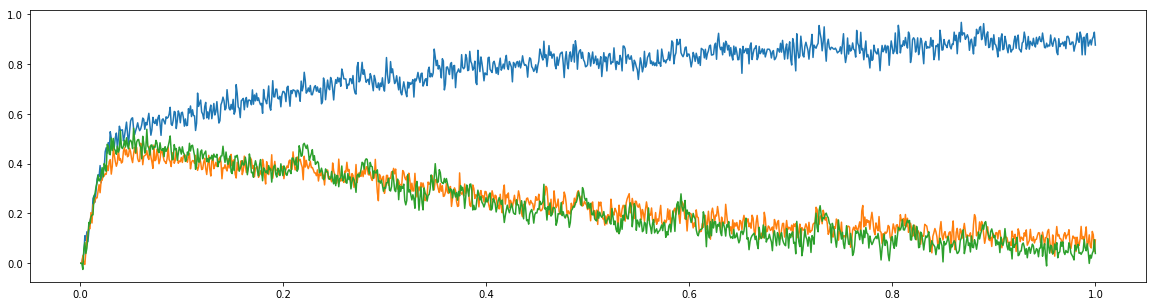

In [433]:
# Class
plt.figure(figsize=(20,5))
plt.plot(sim.trange(), sim.data[probe_pre_1])

# This is the way it should look for class 1
At the end of the previous graph it is similar 

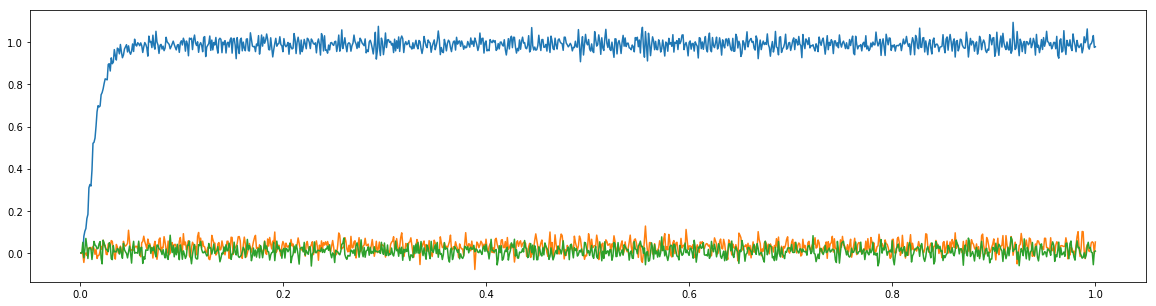

In [434]:
# Pos
plt.figure(figsize=(20,5))
plt.plot(sim.trange(), sim.data[probe_post])

# The error is decreasing with time 

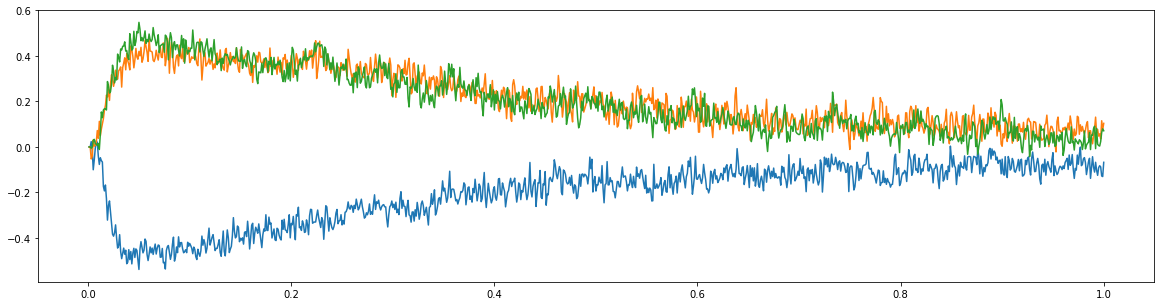

In [435]:
plt.figure(figsize=(20,5))
plt.plot(sim.trange(), sim.data[error_p])